# DC Language Immersion: Mapping Addresses to Feeder Schools 
---
**Author** Glenn Abastillas | **Created** April, 14, 2019 | **Category** Volunteer Work | Language Not-for-Profit

This notebook shows how to assign addresses to school districts in an automated way. The address information comes from the DC Language Immersion Google Drive storage. The school district and ward data comes from the [DC Government's Open Data](www.opendata.dc.gov) APIs.

Update:
    1. July 10, 2019: received data from DC Language Immersion to test boundary school and ward assignment.

---
#### Import Packages

In [1]:
import pandas as pd
import geopandas as gpd
import shapely as shp
import shapefile
import usaddress
import re

from geopy.geocoders import Nominatim
from random import randint

%matplotlib inline

#### Load Map Data

Define the path and label variables for loading map data without the API.

In [2]:
folder = ".."
prefix = 'School_Attendance_Zones'
levels = ['Elementary', 'Middle_School', 'Senior_High', 'Ward']

Load Data and Shape files.

In [3]:
data = {level: pd.read_csv(f"{folder}/{prefix}_{level}.csv") for level in levels}

In [4]:
shapes = {level: shapefile.Reader(f"{folder}/{prefix}_{level}/{prefix}_{level}.shp") for level in levels}

Shape methods include `bbox`, `parts`, `points`, `shapeType`, `shapeTypeName`.

Coordinate information is contained in the `points` attribute. The following cell prints out a random district shape every time it is run.

School boundary #48


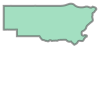

In [5]:
# Set some parameters
level = 'Elementary'
LOW, HI = 0, len(shapes[level].shapes())

# Sample a shape
random_integer = randint(LOW, HI)
example_shape = shp.geometry.Polygon(shapes[level].shape(random_integer).points)
print(f"School boundary #{random_integer}")
example_shape

#### Instantiate Geocoders to Convert Addresses

Instantiate the Geocoder and use it to convert addresses into `Point` objects to allow for inclusion checking.

In [6]:
geocoder = Nominatim(user_agent="default")

Load contact data and information.

In [7]:
raw_contacts = pd.read_csv("dc_language_immersion_contacts.csv").drop_duplicates()
# raw_contacts.columns

# Check if EUID and LEID are actually unique identifiers
print("EUID and LEID truly unique identifiers: ",
(raw_contacts.EUID.unique().shape[0] == raw_contacts.LEID.unique().shape[0] == raw_contacts.shape[0]))

EUID and LEID truly unique identifiers:  True


In [8]:
raw_contacts.TYPE = raw_contacts.TYPE.apply(lambda x: '; '.join([__.title() for __ in x.split(';') if __.strip()]))

contacts = raw_contacts[raw_contacts['Street Address 1'].notnull()]
contacts = contacts[['EUID', 'LEID', 'Street Address 1', 'City', 'State', 'Zip Code']]
contacts.columns = ['euid', 'leid', 'address', 'city', 'state', 'zip']
contacts.shape

(877, 6)

### Clean Up Data
Some contacts' addresses have a DC street address, but out of state city and state designation. These functions help analyze the street address.

In [9]:
def n_tokens(addr):
    return(len(addr.split()))

def valid_quadrant(addr):
    suffix = addr.split()[-1].upper()
    if(suffix not in ['NW', 'NE', 'SE', 'SW']):
        return(False)
    return(True)

The first time the cell below is run, it will show the invalid addresses. After running the subsequent two cells, the next cell should produce an empty `DataFrame`.

In [20]:
contacts[contacts.state.str.lower().str.find('district') > -1]

,euid,leid,address,city,state,zip


In [21]:
valid_quadrant_ = contacts.address.apply(valid_quadrant)
not_washington_ = ~contacts.city.apply(lambda x: 'ashi' in str(x).lower())
state_is_in_dc_ = ((contacts.state.str.lower() == 'dc') | ((contacts.state.str.lower().str.find('district') > -1)))
state_is_an_nan = contacts.state.isnull()

contacts[valid_quadrant_ & not_washington_ & (state_is_in_dc_ | state_is_an_nan)]

,euid,leid,address,city,state,zip


Replace `NaN` city names with Washington if the address is in Washington, DC. Assume that street addresses with quadrant information are in DC.

In [22]:
# contacts.loc[contacts[valid_quadrant_ & not_washington_ & (state_is_in_dc_ | state_is_an_nan)], 'city'] = 'Washington'
# contacts.loc[contacts[valid_quadrant_ & not_washington_ & (state_is_in_dc_ | state_is_an_nan)], 'state'] = 'DC'
contacts.loc[valid_quadrant_ & not_washington_ & (state_is_in_dc_ | state_is_an_nan), 'city'] = 'Washington'
contacts.loc[valid_quadrant_ & (state_is_an_nan), 'state'] = 'DC'

Normalize the city and state data for addresses in Washington, DC. Re-running the cells above should return an empty data frame if successfully processed.

In [23]:
contacts.loc[state_is_in_dc_, 'city'] = 'Washington'
contacts.loc[state_is_in_dc_, 'state'] = 'DC'

Save this second dataset, which contains rows of contacts with a `state=='dc'`

In [24]:
# df2 = contacts.copy()
# df2.to_csv("contacts_washington_dc.csv", index=False)

In [25]:
contacts[state_is_in_dc_].city.unique()

array(['Washington'], dtype=object)

#### Address Analysis

Discover different address types for regular expression normalization. All entries had a `state='DC'`.

In [26]:
contacts.address.unique()[:5]

array(['6100 nebraska ave nw', 'Po box 2194', '8000 Blair Mill Drive',
       '15505 Bounds Ave.', '22 Hesketh Street'], dtype=object)

In [27]:
dc = contacts[state_is_in_dc_]
dc.shape

(497, 6)

#### ZIP
Examine the ZIP codes for all DC rows.

In [28]:
dc.zip.unique()

array(['20015', nan, '20016', '20020', '20024', '20005', '20004', '20009',
       '20012', '20011', '20019', '20045', '20001', '20006', '20036',
       '20010', '20017', '20008', '20002', '20018', '20003', '20064',
       '20032', '20772', '20040', '20853', '22204', '20013', '22311',
       '20019-3802', '20912', '20903', '20037', '20007', '20910', '20090',
       '21061', '20021'], dtype=object)

#### City
Examine the city names for all DC rows.

In [29]:
washington = ('Washington', re.compile(r"\w+?shi\w{0,2}t\w+?|DC|Wa", re.IGNORECASE))
dc[dc.city.apply(lambda x: len(washington[1].findall(str(x))) > 0)].city.unique()

array(['Washington'], dtype=object)

Define a function to get just the `StreetPostType` data from the street addresses.

In [30]:
def get_address_type(street_address):
    try:
        return(usaddress.tag(street_address)[-1])
    except:
        return(None)
    

In [31]:
dc.loc[:,'address_type'] = dc.address.apply(get_address_type)
dc.address_type.value_counts()

/Applications/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Applications/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Street Address    481
Ambiguous           9
PO Box              4
Name: address_type, dtype: int64

##### Quadrant

Check if the street address ends in a quadrant. Separate addresses into two variables.

In [32]:
dc_valid_quadrant = dc[dc.address.apply(valid_quadrant) & dc.city.isin([washington[0]])]
dc_valid_quadrant.shape

(398, 7)

In [33]:
dc_invalid_quadrant = dc[~dc.address.apply(valid_quadrant) & dc.city.isin([washington[0]])]
dc_invalid_quadrant.shape

(99, 7)

Some examples of tokens that end a street address.

In [34]:
dc_invalid_quadrant[dc_invalid_quadrant.address.apply(n_tokens) > 1].address.apply(lambda x: x.split()[-2]).sort_values().unique()

array(['#', '-', '1', '1615', '3rd', '4514', '4th', '9th', 'A', 'APT',
       'Aprt', 'Apt', 'Apt.', 'Ave', 'Belmont', 'Bison', 'Box', 'C',
       'Calvert', 'Cathedral', 'Columbia', 'Connecticut', 'D.C', 'DC',
       'Dakota', 'Douglas', 'F', 'G', 'Hampshire', 'Manor',
       'Massachussets', 'Mercury', 'Mintwood', 'NE', 'NE,', 'NW', 'NW,',
       'Oakview', 'Osborn', 'Place', 'Pomeroy', 'Quebec', 'Rd.', 'S',
       'SE', 'SE,', 'Suite', 'Unit', 'Virginia', 'Vista', 'York', 'apt',
       'box', 'columbia', 'dc', 'florida', 'harvard', 'l', 'nw', 'sports'],
      dtype=object)

The next cell investigates the type of suffixes for the valid quadrant data for regular expression development.

In [35]:
dc_valid_quadrant[dc_valid_quadrant.address.apply(n_tokens) > 1].address.apply(lambda x: x.split()[-2]).sort_values().unique()

array(['Alley', 'Av.', 'Ave', 'Ave,', 'Ave.', 'Avenue', 'Avenue,',
       'Branch', 'CT', 'Ct', 'Dr', 'Dr.', 'Ln', 'PL', 'PL,', 'Pl',
       'Place', 'Place,', 'Rd', 'Rd,', 'Road', 'ST', 'ST.', 'STREET',
       'St', 'St.', 'St.,', 'Street', 'Street,', 'Waltman', 'Way', 'ave',
       'dr', 'dr.', 'pl', 'place', 'road', 'st', 'st.', 'street',
       'street,', 'way'], dtype=object)

### Regular Expressions for Normalizing Addresses
Regular expressions can be used to standardize the address names. First create a shorthand variable name for the two types of quadrant classifications.

In [36]:
dcv = dc_valid_quadrant
dci = dc_invalid_quadrant

Now create the regular expressions to detect the street entities and the replacement term. These post types were determined by examining the data.

In [37]:
import re

types = [('alley',          r'all?e?y'), 
         ('avenue',         r'av(\w+)?\S?'), 
         ('boulevard',     r'b\w{0,2}l\w?v\w?r?d'),
         ('branch',         r'branch\S?'), 
         ('court',          r'c[ou]{0,2}r?t\S?'), 
         ('drive',          r'dr(ive)?\S?'), 
         ('lane',           r'l\w?n\w?\S?'), 
         ('place',          r'pl(ace)?\S?'), 
         ('road',           r'r[oa]{0,2}d\S?'), 
         ('street',         r'st(ree?t)?\S?'), 
         ('way',            r'wa?y')]

types_dict = dict([(a, re.compile(b, re.IGNORECASE)) for a, b in types])

Test the regular expressions on an example.

In [38]:
# example = ' 2342 Nebraska av.'
# [types_dict[key].sub(key, example) for key in types_dict.keys()]

Define functions to normalize street address strings.

In [39]:
def get_address_type(A):
    """ See if input address `A` is a Street Address, PO Box, Ambiguous, or None """
    try:
        return(usaddress.tag(A)[-1])
    except:
        return(None)

def get_occupancy_identifier(address):
    if(address):
        try:
            parsed, street_type = usaddress.tag(address)
            return(parsed['OccupancyIdentifier'])
        except:
            return(None)
    return(address)
    
def normalize_posttype(P, tdict=types_dict):
    for key in tdict:
        regex = tdict[key]
        if(regex.findall(P)):
            return(regex.sub(key, P))
    return(P)

def normalize_address(A):
    try:
        parsed, street_type = usaddress.tag(A)
        A = parsed['AddressNumber'].replace('.', '')
        B = parsed['StreetName'].replace('.', '')
        
        # Process StreetNames if numeric
        B = B.lower() if B[0].isdigit() else B.title()
        B = f"{B}th" if (B.isdigit()) else (f"{B[:-2]}th" if (B[:-2].isdigit()) else B)
        B = f"{B[:-2]}st" if B[:-2].isdigit() and (B[:-2] == '1' or B[-3] == '1') else B
        B = f"{B[:-2]}nd" if B[:-2].isdigit() and (B[:-2] == '2' or B[-3] == '2' and B[0] != '1') else B
        B = f"{B[:-2]}rd" if B[:-2].isdigit() and (B[:-2] == '3' or B[-3] == '3' and B[0] != '1') else B
        
        C = normalize_posttype(parsed['StreetNamePostType']).title()
            
        try:
            D = parsed['StreetNamePostDirectional'].upper()
        except:
            D = ''
        return(f"{A} {B} {C} {D}".replace('.', '').strip())
        
    except:
#         print(A)
        return(None)

Normalize the addresses of the original dataset `contacts`.

In [40]:
contacts = contacts.assign(address_type=contacts.address.apply(get_address_type),
                           occupancy_identifier=contacts.address.apply(get_occupancy_identifier))
contacts.address_type.value_counts()

Street Address    840
Ambiguous          22
PO Box              9
Name: address_type, dtype: int64

In [43]:
contacts.loc[contacts.address_type.isin(['Street Address']),].assign(address_norm=contacts.address.apply(normalize_address)).sample(10)

,euid,leid,address,city,state,zip,address_type,occupancy_identifier,address_norm
1373,79602c28fd,581753197.0,24 Hamilton St NE,Washington,DC,20011,Street Address,None,24 Hamilton Street NE
1481,d418729040,581753497.0,410 Evarts St NE,Washington,DC,20017,Street Address,None,410 Evarts Street NE
1314,891521ce5f,527236721.0,100 Gallatin St NE,Washington,DC,20011,Street Address,None,100 Gallatin Street NE
1858,4140e89fbb,587253317.0,5225 olley ln,burke,VA,22015,Street Address,None,5225 Olley Lane
123,ccc1b2dfd9,582728757.0,"4058 Minnesota Ave NE, Suite 5000",Washington,DC,20019,Street Address,5000,4058 Minnesota Avenue NE
1070,8a12c702b6,587254557.0,1027 45th St NE,Washington,DC,20019-3802,Street Address,None,1027 45th Street NE
527,d1aaf37d69,260315025.0,2142 Branch Ave SE,Washington,DC,20020,Street Address,None,2142 Branch Avenue SE
2367,454a9411cb,587253209.0,1105 Cardigan Road,Middletown,DE,19709,Street Address,None,1105 Cardigan Road
1031,3a5c009d9a,587253321.0,2115 11th St NW,Washington,DC,20001,Street Address,None,2115 11st Street NW
1453,b09984cf51,581753333.0,1216 Constitution Ave NE,Washington,DC,20002,Street Address,None,1216 Constitution Avenue NE


In [44]:
dc = contacts[state_is_in_dc_ & (contacts.address_type == 'Street Address')]
not_dc = contacts[~state_is_in_dc_ & (contacts.address_type == 'Street Address')]
print(f"R,C: {dc.shape[0]} contacts with Street Addresses in DC\n"
      f"R,C: {not_dc.shape[0]} contacts without Street Addresses in DC\n"
      f"R,C: {contacts.shape[0]} total contacts.")

R,C: 481 contacts with Street Addresses in DC
R,C: 359 contacts without Street Addresses in DC
R,C: 877 total contacts.


### Assign Dataset to `current`

Assign which dataset to focus on with the `current` variable.

In [96]:
current = contacts[contacts.address_type.isin(['PO Box']) & state_is_in_dc_]

Continue to process the street addresses.

In [97]:
current_st = current[current.address_type.isin(['PO Box'])]

print(current_st.shape)
current_st.address.sample(10, replace=True).apply(normalize_address)

(4, 8)


1920    None
769     None
769     None
2401    None
769     None
2401    None
769     None
769     None
332     None
332     None
Name: address, dtype: object

In [98]:
current_st = current_st.assign(address_clean=current_st.address.apply(normalize_address))

In [99]:
# address = "1160 1st Street NE, Washington DC 20002"
address = ', '.join(current_st.sample()[['address_clean', 'city', 'state', 'zip']].iloc[0])
location = geocoder.geocode(address)
print(address)

TypeError: sequence item 0: expected str instance, NoneType found

Get the location point coordinates and check for inclusion.

In [101]:
location_point = shp.geometry.Point(tuple(location.point))
example_shape.contains(location_point)

False

#### Tester to Find School District for Address

First design the logic then create the function definition.

In [ ]:
level = levels[2]
SIZE = 0, len(shapes[level].shapes())

for i in range(len(SIZE)):
    current = shp.geometry.Polygon(shapes[level].shape(i).points)
    if(current.contains(location_point)):
        break

# shape = shapes[level].shape(i)        
print(f"Your {level} school for {address} is {i}.")
current

In [50]:
location

Location(79, V Street Northwest, Bloomingdale, Washington, D.C., 20001, USA, (38.9182965, -77.011503288806, 0.0))

In [56]:
from shapely.geometry import Point, Polygon
from geopy.geocoders import Here
from geopy.exc import GeocoderTimedOut

geocoder = Here(app_id="Yc3DwCnHtBBIqRwBCyHS",
                app_code="M_6pX8o174Ny1Ifs536-kg")

def get_coordinates(address, i=3):
    """ Return the longitude, latitude, and altitude of an address as a tuple """
    if(i > -1):
        if(address):
            try:
                return(tuple(geocoder.geocode(address).point))
            except(GeocoderTimedOut):
                return(get_coordinates(address, i-1))
    return(None)
    
def assign_school_zone(address, school_data=data, shape_data=shapes, school_levels=levels, level=0):
    """ Return school name, object ID, and Ward number. """
    if(address):
        longitude, latitude, altitude = address

        point = Point((latitude, longitude))
        school = school_levels[level] if isinstance(level, int) else level

        for i, shape in enumerate(shape_data[school].shapes()):
            polygon = Polygon(shape.points)
            if(polygon.contains(point)):
                return(i+1, f"{school_data[school].loc[i,'NAME']} {school.replace('_', ' ')}")
    return(None)

def assign_school_zone_chunk(address_chunk):
    for address, euid, leid in address_chunk:
    boundary = list()
    address_ = get_coordinates
                       
def boundary_and_ward(street_addresses):
    from threading import Thread
    import numpy as np
    
    chunks = np.array_split(street_addresses, 100)
    
    threads = list()
    for chunk in chunks:
        thread_ = Thread(target=assign_school_zone_chunk, args=(,))
    

### Deploy School Zone Assignment Algorithm

Test the algorithm on a single address and then multiple addresses.

In [57]:
coords = get_coordinates(address)
print(address, assign_school_zone(coords, data, shapes, levels, 'Middle_School'))

2101 Martin Luther King Jr Avenue SE Washington DC 20020 (13, 'Kramer Middle School')


### Get Boundary and Ward Information

Run the cell to get `boundary school` and `ward` information for each address.

In [63]:
from tqdm import tqdm
import time
# addresses = ['1150 1st street ne', '1822 1st St NW, Washington, DC 20001', '1918 14th St SE, Washington, DC 20020']

DATA = current_st
decide = lambda x: x if x else ''
addresses = [(f"{decide(a)} {decide(b)} {decide(c)} {decide(d)}".strip(), e, f) 
             for i, (a, b, c, d, e, f) in list(DATA[['address_clean', 'city', 'state', 'zip', 'euid', 'leid']].iterrows())]

address_boundary = list()

for address, euid, leid in tqdm(addresses):
    boundary = list()
    address_ = get_coordinates(address)

    for level in levels:
        try:
            school = assign_school_zone(address_, level=level)[1]
            boundary.append(school)
        except:
            pass
    address_boundary.append(tuple([euid, leid, address_, address] + boundary))
    time.sleep(1)

len(address_boundary)

100%|██████████| 481/481 [09:29<00:00,  1.18s/it]


481

Address and boundary schools from the `dci` (`dc_invalid_quadrant`) data set.

In [ ]:
# ab_dci = address_boundary # Comment out once assigned to allow the list above to get reassigned
len(ab_dci)

Address and boundary schools from the `dcv` (`dc_valid_quadrant`) data set.

In [ ]:
# ab_dcv = address_boundary # Comment out once assigned to allow the list above to get reassigned
len(ab_dcv)

Create a new DataFrame to hold processed data.

In [65]:
processed = pd.DataFrame(address_boundary, columns=['euid', 'leid', 'coords', 'address',
                                                    'elementary_school', 'middle_school', 'senior_school', 'ward'])
processed.shape

(481, 8)

In [66]:
processed.head()

,euid,leid,coords,address,elementary_school,middle_school,senior_school,ward
0,088dea985f,583601593.0,"(38.97001, -77.05589, 0.0)",6100 Nebraska Avenue NW Washington DC 20015,Lafayette Elementary,Deal Middle School,Wilson Senior High,Ward 4 Ward
1,54ca72b5b7,581755493.0,"(38.92323, -76.95232, 0.0)",3722 Hansberry Court NE Washington DC nan,Langdon Elementary,McKinley Middle School,Dunbar Senior High,Ward 5 Ward
2,4da6a57e31,581755361.0,"(38.88612, -76.9804, 0.0)",1704 Massachusetts Avenue SE Washington DC nan,Payne Elementary,Eliot-Hine Middle School,Eastern Senior High,Ward 6 Ward
3,29e799a000,289867661.0,"(38.94655, -77.08462, 0.0)",4317 Yuma Street NW Washington DC 20016,Janney Elementary,Deal Middle School,Wilson Senior High,Ward 3 Ward
4,d216f60a89,585976581.0,"(38.86542, -76.99018, 0.0)",2101 Martin Luther King Jr Avenue SE Washingto...,Ketcham Elementary,Kramer Middle School,Anacostia Senior High,Ward 8 Ward


Number of addresses where there is no boundary school information available at all for the addresses.

In [67]:
has_all_school_levels = ~(processed.senior_school.isnull() & processed.middle_school.isnull() & processed.elementary_school.isnull())

In [68]:
processed[~has_all_school_levels].shape

(6, 8)

Look into the address where there is a school available.

In [75]:
processed = processed.assign(ward=processed.ward.str[:-4])

In [76]:
processed.sample(20)

,euid,leid,coords,address,elementary_school,middle_school,senior_school,ward
424,01fc89ac4a,587255025.0,"(38.92939, -76.96422, 0.0)",102 Vista Avenue Washington DC 21061,Langdon Elementary,McKinley Middle School,Dunbar Senior High,Ward 5
188,c60816575e,587253097.0,"(38.85678, -76.98629, 0.0)",2347 Pomeroy Road Washington DC 20020,Moten Elementary,Kramer Middle School,Anacostia Senior High,Ward 8
26,ca0464d90e,527097285.0,"(38.91714, -77.03483, 0.0)",1501 U Street NW Washington DC 20009,Garrison Elementary,Shaw Middle School,Cardozo Senior High,Ward 1
246,239b7a4c15,581753225.0,"(38.9524, -77.02944, 0.0)",5107 13th Street NW Washington DC 20011,West Elementary,MacFarland Middle School,Roosevelt Senior High,Ward 4
378,b6581a4061,581753193.0,"(38.95405, -77.02246, 0.0)",702 Ingraham Street NW Washington DC 20011,Truesdell Elementary,MacFarland Middle School,Roosevelt Senior High,Ward 4
415,0cf84d2bc2,587253445.0,"(38.8965908, -76.9927549, 0.0)",512 10th Street NE Washington DC 20002,Ludlow-Taylor Elementary,Stuart-Hobson Middle School,Eastern Senior High,Ward 6
418,b963bcb18d,581753297.0,"(38.92503, -77.02886, 0.0)",1225 Fairmont Street NW Washington DC 20009,Tubman Elementary,Columbia Heights Middle School,Cardozo Senior High,Ward 1
222,50253eec25,581753285.0,"(38.93404, -77.03421, 0.0)",1438 Oak Street NW Washington DC 20010,Raymond Elementary,MacFarland Middle School,Roosevelt Senior High,Ward 1
478,d8b6469183,584716573.0,"(38.91138, -77.04637, 0.0)",1601 21st Street NW Washington DC nan,School Without Walls @ Francis-Stevens Elementary,School Without Walls @ Francis-Stevens Middle ...,Cardozo Senior High,Ward 2
184,175ebe60b6,587254629.0,"(38.88168, -77.01681, 0.0)",301 G Street SW Washington DC 20024,Amidon-Bowen Elementary,Jefferson Middle School,Eastern Senior High,Ward 6


Save current processed DataFrame.

In [77]:
processed.to_csv("./processed.csv", index=False)

#### Merge Back to Original Data

Using the street address, city, and state columns, merged cleaned and assigned data back to main dataset. First, separate out the street address.

In [78]:
processed = processed.assign(street_address=processed.address.apply(lambda x: ' '.join(x.split()[:-3])))
processed.head()

,euid,leid,coords,address,elementary_school,middle_school,senior_school,ward,street_address
0,088dea985f,583601593.0,"(38.97001, -77.05589, 0.0)",6100 Nebraska Avenue NW Washington DC 20015,Lafayette Elementary,Deal Middle School,Wilson Senior High,Ward 4,6100 Nebraska Avenue NW
1,54ca72b5b7,581755493.0,"(38.92323, -76.95232, 0.0)",3722 Hansberry Court NE Washington DC nan,Langdon Elementary,McKinley Middle School,Dunbar Senior High,Ward 5,3722 Hansberry Court NE
2,4da6a57e31,581755361.0,"(38.88612, -76.9804, 0.0)",1704 Massachusetts Avenue SE Washington DC nan,Payne Elementary,Eliot-Hine Middle School,Eastern Senior High,Ward 6,1704 Massachusetts Avenue SE
3,29e799a000,289867661.0,"(38.94655, -77.08462, 0.0)",4317 Yuma Street NW Washington DC 20016,Janney Elementary,Deal Middle School,Wilson Senior High,Ward 3,4317 Yuma Street NW
4,d216f60a89,585976581.0,"(38.86542, -76.99018, 0.0)",2101 Martin Luther King Jr Avenue SE Washingto...,Ketcham Elementary,Kramer Middle School,Anacostia Senior High,Ward 8,2101 Martin Luther King Jr Avenue SE


Now, attempt to merge the datasets.

In [79]:
merged = contacts.merge(processed, on=['euid', 'leid'])
merged.head()

,euid,leid,address_x,city,state,zip,address_type,occupancy_identifier,coords,address_y,elementary_school,middle_school,senior_school,ward,street_address
0,088dea985f,583601593.0,6100 nebraska ave nw,Washington,DC,20015,Street Address,None,"(38.97001, -77.05589, 0.0)",6100 Nebraska Avenue NW Washington DC 20015,Lafayette Elementary,Deal Middle School,Wilson Senior High,Ward 4,6100 Nebraska Avenue NW
1,54ca72b5b7,581755493.0,3722 Hansberry CT NE,Washington,DC,NaN,Street Address,None,"(38.92323, -76.95232, 0.0)",3722 Hansberry Court NE Washington DC nan,Langdon Elementary,McKinley Middle School,Dunbar Senior High,Ward 5,3722 Hansberry Court NE
2,4da6a57e31,581755361.0,1704 Massachusetts Avenue SE,Washington,DC,NaN,Street Address,None,"(38.88612, -76.9804, 0.0)",1704 Massachusetts Avenue SE Washington DC nan,Payne Elementary,Eliot-Hine Middle School,Eastern Senior High,Ward 6,1704 Massachusetts Avenue SE
3,29e799a000,289867661.0,4317 Yuma St NW,Washington,DC,20016,Street Address,None,"(38.94655, -77.08462, 0.0)",4317 Yuma Street NW Washington DC 20016,Janney Elementary,Deal Middle School,Wilson Senior High,Ward 3,4317 Yuma Street NW
4,d216f60a89,585976581.0,2101 Martin Luther King Jr. Ave SE,Washington,DC,20020,Street Address,None,"(38.86542, -76.99018, 0.0)",2101 Martin Luther King Jr Avenue SE Washingto...,Ketcham Elementary,Kramer Middle School,Anacostia Senior High,Ward 8,2101 Martin Luther King Jr Avenue SE


In [80]:
merged.shape

(481, 15)

In [81]:
merged.to_csv("./merged_1.csv", index=False)

In [82]:
merged.to_clipboard(index=False)

#### Connecting via API

Sandbox for reading in School Attendance Zones for Senior High School from the Open Data repository.

In [ ]:
api_data = gpd.read_file("https://opendata.arcgis.com/datasets/d2e0486155144b6d8e11e12469a64b1c_15.geojson")
api_data.head(2)

In [ ]:
geometry = api_data['geometry']

In [ ]:
geometry.head()

In [ ]:
shape1 = Polygon(geometry[1])

In [ ]:
api_data.plot(label='NAME')

In [ ]:
geojson_copy = "https://opendata.arcgis.com/datasets/d2e0486155144b6d8e11e12469a64b1c_15.geojson"

---

# END